<a href="https://colab.research.google.com/github/Kadakol/ML/blob/master/NYU%20Deep%20Learning%20DS-GA%201008/Spring%202020/Practicum/05_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from IPython.display import HTML, display


def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)


def show_scatterplot(X, colors, title=''):
    colors = colors.cpu().numpy()
    X = X.cpu().numpy()
    plt.figure()
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=30)
    # plt.grid(True)
    plt.title(title)
    plt.axis('off')


def plot_bases(bases, width=0.04):
    bases = bases.cpu()
    bases[2:] -= bases[:2]
    plt.arrow(*bases[0], *bases[2], width=width, color=(1,0,0), zorder=10, alpha=1., length_includes_head=True)
    plt.arrow(*bases[1], *bases[3], width=width, color=(0,1,0), zorder=10, alpha=1., length_includes_head=True)


def show_mat(mat, vect, prod, threshold=-1):
    # Subplot grid definition
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=True,
                                        gridspec_kw={'width_ratios':[5,1,1]})
    # Plot matrices
    cax1 = ax1.matshow(mat.numpy(), clim=(-1, 1))
    ax2.matshow(vect.numpy(), clim=(-1, 1))
    cax3 = ax3.matshow(prod.numpy(), clim=(threshold, 1))

    # Set titles
    ax1.set_title(f'A: {mat.size(0)} \u00D7 {mat.size(1)}')
    ax2.set_title(f'a^(i): {vect.numel()}')
    ax3.set_title(f'p: {prod.numel()}')

    # Remove xticks for vectors
    ax2.set_xticks(tuple())
    ax3.set_xticks(tuple())
    
    # Plot colourbars
    fig.colorbar(cax1, ax=ax2)
    fig.colorbar(cax3, ax=ax3)

    # Fix y-axis limits
    ax1.set_ylim(bottom=max(len(prod), len(vect)) - 0.5)


colors = dict(
    aqua='#8dd3c7',
    yellow='#ffffb3',
    lavender='#bebada',
    red='#fb8072',
    blue='#80b1d3',
    orange='#fdb462',
    green='#b3de69',
    pink='#fccde5',
    grey='#d9d9d9',
    violet='#bc80bd',
    unk1='#ccebc5',
    unk2='#ffed6f',
)


def _cstr(s, color='black'):
    if s == ' ':
        return f'<text style=color:#000;padding-left:10px;background-color:{color}> </text>'
    else:
        return f'<text style=color:#000;background-color:{color}>{s} </text>'

# print html
def _print_color(t):
    display(HTML(''.join([_cstr(ti, color=ci) for ti, ci in t])))

# get appropriate color for value
def _get_clr(value):
    colors = ('#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
              '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
              '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
              '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e')
    value = int((value * 100) / 5)
    if value == len(colors): value -= 1  # fixing bugs...
    return colors[value]

def _visualise_values(output_values, result_list):
    text_colours = []
    for i in range(len(output_values)):
        text = (result_list[i], _get_clr(output_values[i]))
        text_colours.append(text)
    _print_color(text_colours)

def print_colourbar():
    color_range = torch.linspace(-2.5, 2.5, 20)
    to_print = [(f'{x:.2f}', _get_clr((x+2.5)/5)) for x in color_range]
    _print_color(to_print)


# Let's only focus on the last time step for now
# First, the cell state (Long term memory)
def plot_state(data, state, b, decoder):
    actual_data = decoder(data[b, :, :].numpy())
    seq_len = len(actual_data)
    seq_len_w_pad = len(state)
    for s in range(state.size(2)):
        states = torch.sigmoid(state[:, b, s])
        _visualise_values(states[seq_len_w_pad - seq_len:], list(actual_data))

## Create the data

In [2]:
import random
import torch
from torch import nn, optim
import math
from IPython import display

In [3]:
from matplotlib import pyplot as plt

In [4]:
set_default()

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
seed = 1
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 1  # dimensions
C = 1  # num_classes
H = 100  # num_hidden_units

In [7]:
X = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1).to(device)
y = X.pow(3) + 0.3 * torch.rand(X.size()).to(device)

In [10]:
print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (100, 1)
y: (100, 1)


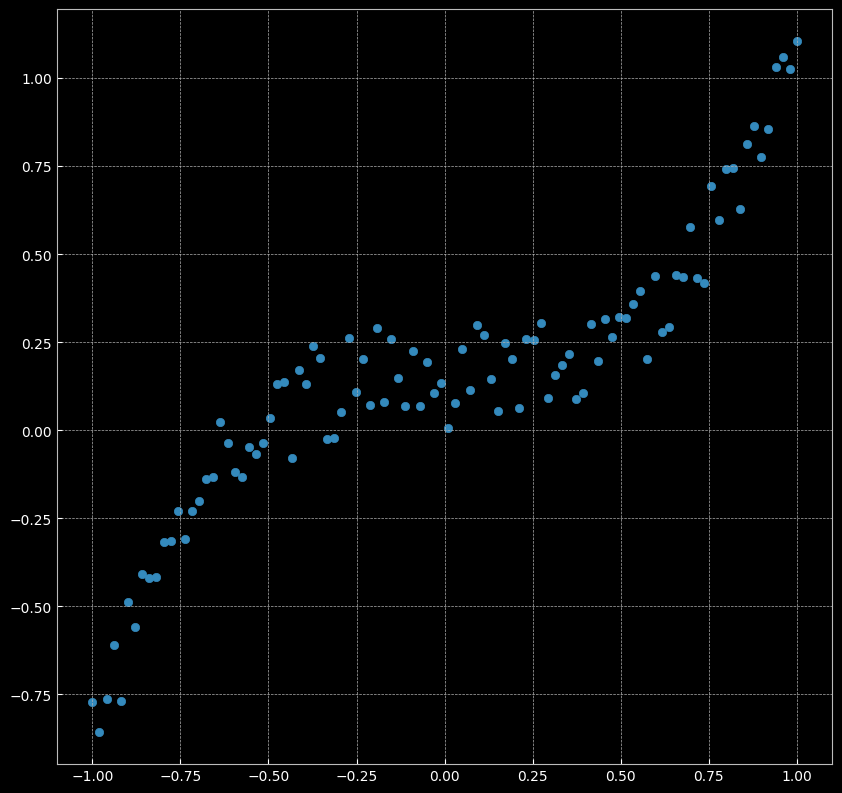

In [11]:
plt.scatter(X.cpu().numpy(), y.cpu().numpy())
plt.axis('equal');

## Linear Model

In [15]:
lr = 1e-3
weight_decay = 1e-5

In [17]:
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

for epoch in range(1000):
  y_pred = model(X)
  loss = criterion(y_pred, y)
  print(f'Epoch = {epoch}\tLoss = {loss:.6f}')
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch = 0	Loss = 0.671100
Epoch = 1	Loss = 0.590285
Epoch = 2	Loss = 0.516163
Epoch = 3	Loss = 0.448708
Epoch = 4	Loss = 0.387901
Epoch = 5	Loss = 0.333663
Epoch = 6	Loss = 0.285842
Epoch = 7	Loss = 0.244210
Epoch = 8	Loss = 0.208452
Epoch = 9	Loss = 0.178167
Epoch = 10	Loss = 0.152877
Epoch = 11	Loss = 0.132042
Epoch = 12	Loss = 0.115085
Epoch = 13	Loss = 0.101416
Epoch = 14	Loss = 0.090461
Epoch = 15	Loss = 0.081680
Epoch = 16	Loss = 0.074590
Epoch = 17	Loss = 0.068768
Epoch = 18	Loss = 0.063868
Epoch = 19	Loss = 0.059616
Epoch = 20	Loss = 0.055810
Epoch = 21	Loss = 0.052317
Epoch = 22	Loss = 0.049061
Epoch = 23	Loss = 0.046015
Epoch = 24	Loss = 0.043189
Epoch = 25	Loss = 0.040614
Epoch = 26	Loss = 0.038336
Epoch = 27	Loss = 0.036401
Epoch = 28	Loss = 0.034848
Epoch = 29	Loss = 0.033698
Epoch = 30	Loss = 0.032954
Epoch = 31	Loss = 0.032595
Epoch = 32	Loss = 0.032579
Epoch = 33	Loss = 0.032844
Epoch = 34	Loss = 0.033315
Epoch = 35	Loss = 0.033907
Epoch = 36	Loss = 0.034538
Epoch = 37	

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=1, bias=True)
)


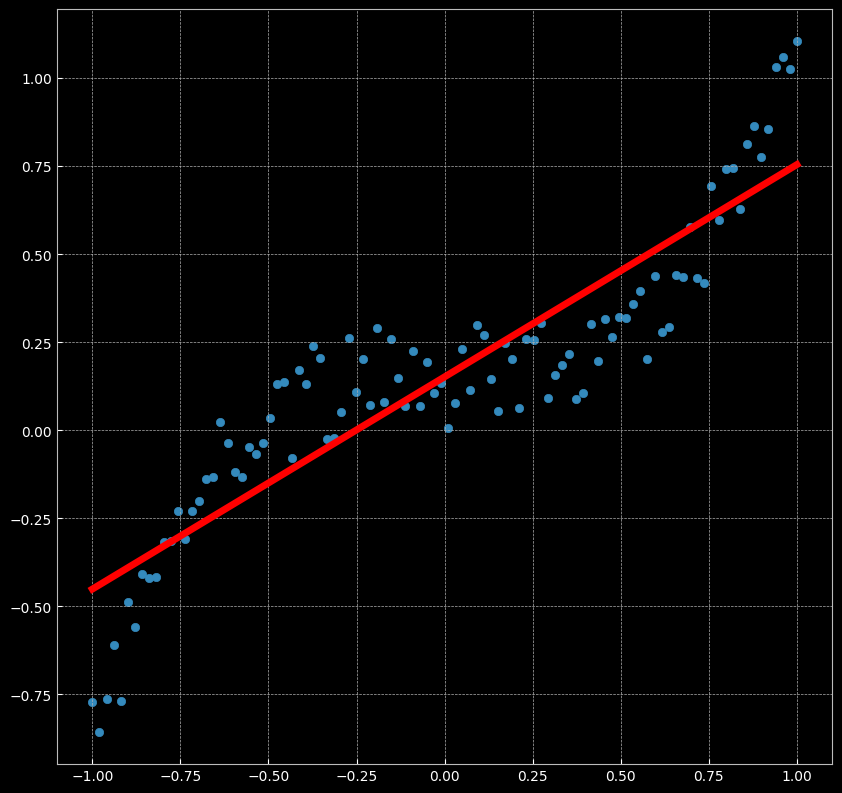

In [19]:
print(model)
plt.scatter(X.data.cpu().numpy(), y.data.cpu().numpy())
plt.plot(X.data.cpu().numpy(), y_pred.data.cpu().numpy(), 'r-', lw=5)
plt.axis('equal');

## Two Layer Network

In [26]:
lr = 1e-3
weight_decay = 1e-5

In [27]:
# Number of networks
n_networks = 10
models = list()
y_pretrain = list()

criterion = nn.MSELoss()

for n in range(n_networks):
  model = nn.Sequential(
      nn.Linear(D, H),
      nn.ReLU() if n < n_networks // 2 else nn.Tanh(),
      nn.Linear(H, C)
  )
  model.to(device)
  models.append(model)

  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

  for epoch in range(1000):
    y_pred = model(X)
    if epoch == 0:
      y_pretrain.append(y_pred.detach())
    loss = criterion(y_pred, y)
    print(f'Epoch = {epoch}\tLoss = {loss.item():.6f}')
    display.clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch = 999	Loss = 0.019373


In [28]:
print(models[0], models[-1])

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
) Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Tanh()
  (2): Linear(in_features=100, out_features=1, bias=True)
)


## Predictions: Before Training

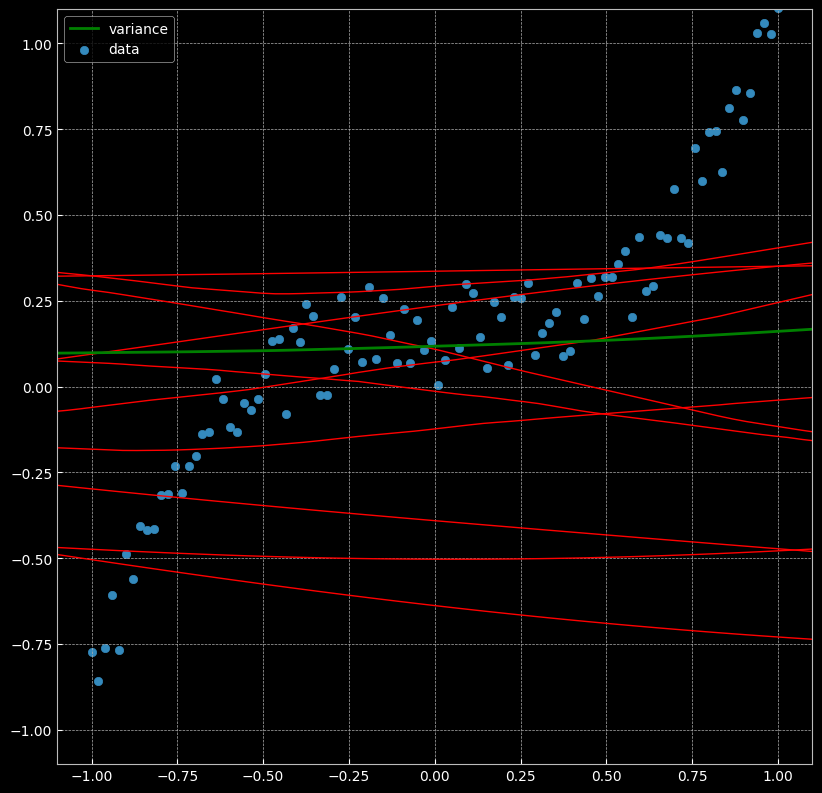

In [29]:
for y_pretrain_idx in y_pretrain:
    # New X that ranges from -5 to 5 instead of -1 to 1
    X_new = torch.unsqueeze(torch.linspace(-2, 2, 100), dim=1)
        
    plt.plot(X_new.numpy(), y_pretrain_idx.cpu().numpy(), 'r-', lw=1)

plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='data')
plt.axis('square')
plt.axis((-1.1, 1.1, -1.1, 1.1));
y_combo = torch.stack(y_pretrain)
plt.plot(X_new.numpy(), y_combo.var(dim=0).cpu().numpy(), 'g', label='variance');
plt.legend()

## Predictions: After Training

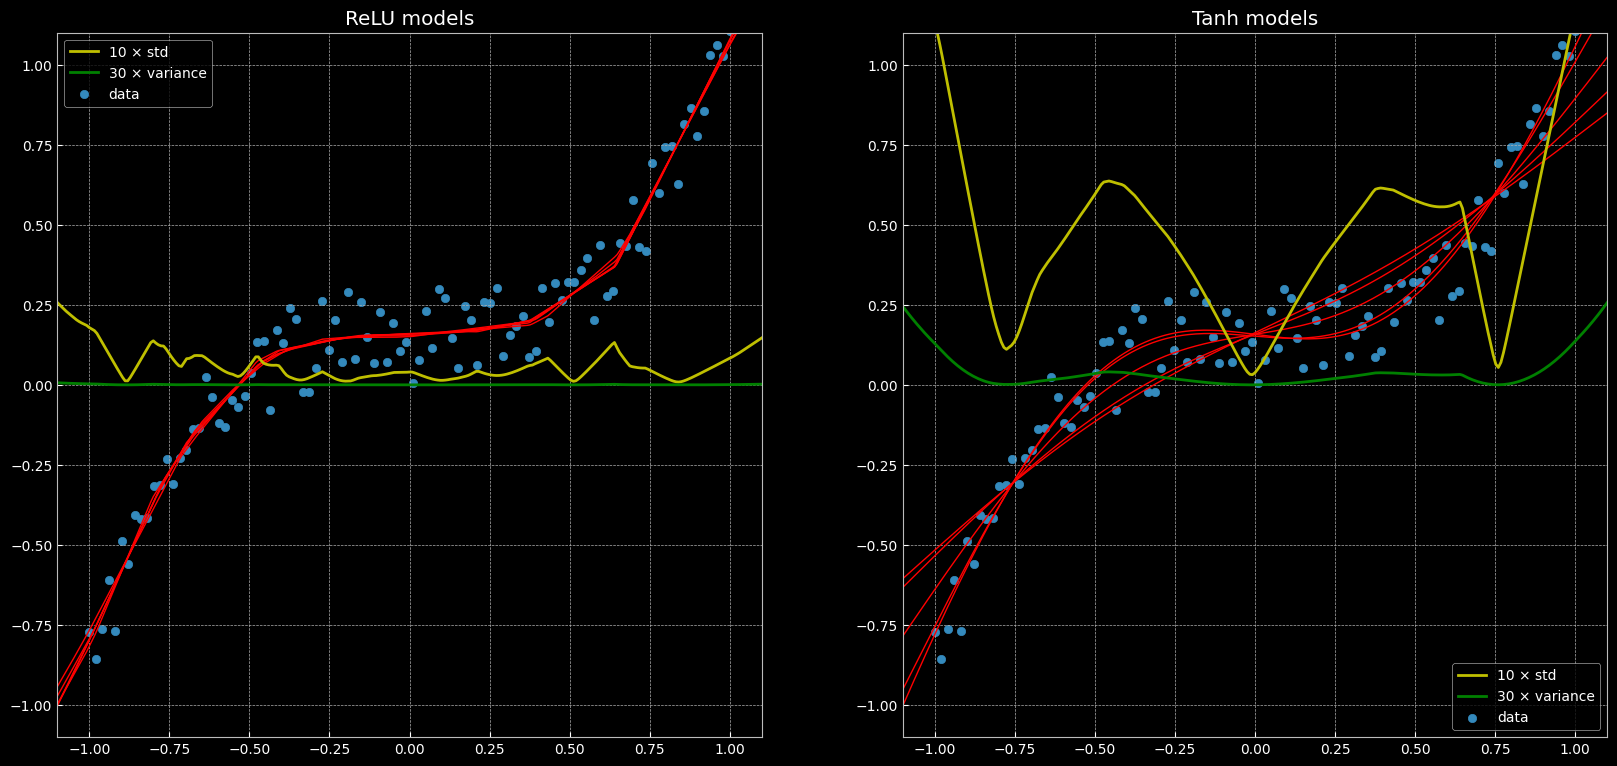

In [30]:
y_pred = list()
relu_models = models[:n_networks // 2]
tanh_models = models[n_networks // 2:]
plt.figure(figsize=(20, 10))

def dense_prediction(models, non_linearity, zoom):
    plt.subplot(1, 2, 1 if non_linearity == 'ReLU' else 2)
    for model in models:
        # New X that ranges from -5 to 5 instead of -1 to 1
        X_new = torch.unsqueeze(torch.linspace(-4, 4, 1001), dim=1).to(device)

        # Getting predictions from input
        with torch.no_grad():
            y_pred.append(model(X_new))

        plt.plot(X_new.cpu().numpy(), y_pred[-1].cpu().numpy(), 'r-', lw=1)
    plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='data')
    plt.axis('square')
    plt.axis(torch.tensor((-1.1, 1.1, -1.1, 1.1)) * zoom);
    y_combo = torch.stack(y_pred)
    plt.plot(X_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().sqrt().numpy(), 'y', label='10 × std')
    plt.plot(X_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().numpy(), 'g', label='30 × variance')
    plt.legend()
    plt.title(non_linearity + ' models')

z = 1  # try 1 or 4
dense_prediction(relu_models, 'ReLU', zoom=z)
dense_prediction(tanh_models, 'Tanh', zoom=z)

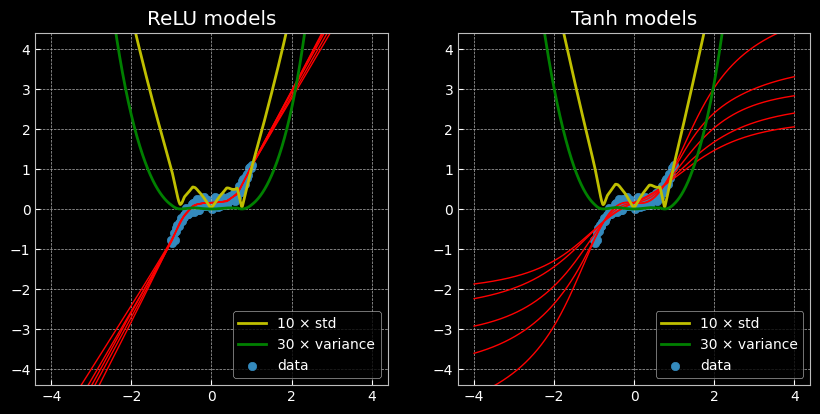

In [31]:
z = 4  # try 1 or 4
dense_prediction(relu_models, 'ReLU', zoom=z)
dense_prediction(tanh_models, 'Tanh', zoom=z)